In [1]:
import numpy as np

from commons import *
from dataset_loader import load_images, prepare_dataset
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import pickle
from keras.models import load_model


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'
ARTIFACTS_SRC = 'hit-images-final2/artefact'

DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/tracks_100000.h5'
WORMS_AC = 'cache/worms_100000.h5'
ARTIFACTS_AC = 'cache/artifacts_100000.h5'

dots_set =  prepare_dataset(load_images(DOTS_SRC))
worms_set =  prepare_dataset(load_images(WORMS_SRC))
tracks_set =  prepare_dataset(load_images(TRACKS_SRC))
artifacts_set =  prepare_dataset(load_images(ARTIFACTS_SRC))

dots_autoencoder = load_model(DOTS_AC)
worms_autoencoder = load_model(WORMS_AC)
tracks_autoencoder = load_model(TRACKS_AC)
artifacts_autoencoder = load_model(ARTIFACTS_AC)

In [2]:
def count_non_black_pixels(image):
    """
    Zwraca liczbę nieczarnych pikseli z obrazka.

    :param image: obrazek.
    :return: liczba nieczarnych pikseli.
    """
    return np.count_nonzero(image)


def compute_errors(image, recon, dm_func, normalize=True):
    """
    Obliczanie błędu.

    :param image: obrazek źródłowy.
    :param recon: rekonstrukcja.
    :param dm_func: funkcja porównująca, jako parametr przyjmuje (image, recon), zwraca skalar będący miarą podobieństwa.
    :param normalize: jeśli true, to dzieli wynik dm_func przez liczbę nieczarnych pikseli z image.
    :return: tablica
    """
    return dm_func(image, recon, normalize)


def prepare_for_histogram(images, reconstructions, dm_func, normalize=True, cutoff_background=False, binarize_for_compare=False):
    errors = []
    for (image, recon) in zip(images, reconstructions):
        try:
            if cutoff_background:
                recon = cutoff_reconstruction_background(image, recon)
            if binarize_for_compare:
                image = binarize_image(image)
                recon = binarize_image(recon)
            mse = compute_errors(image, recon, dm_func, normalize)
            errors.append(mse)
        except:
            errors.append(0)
    return errors

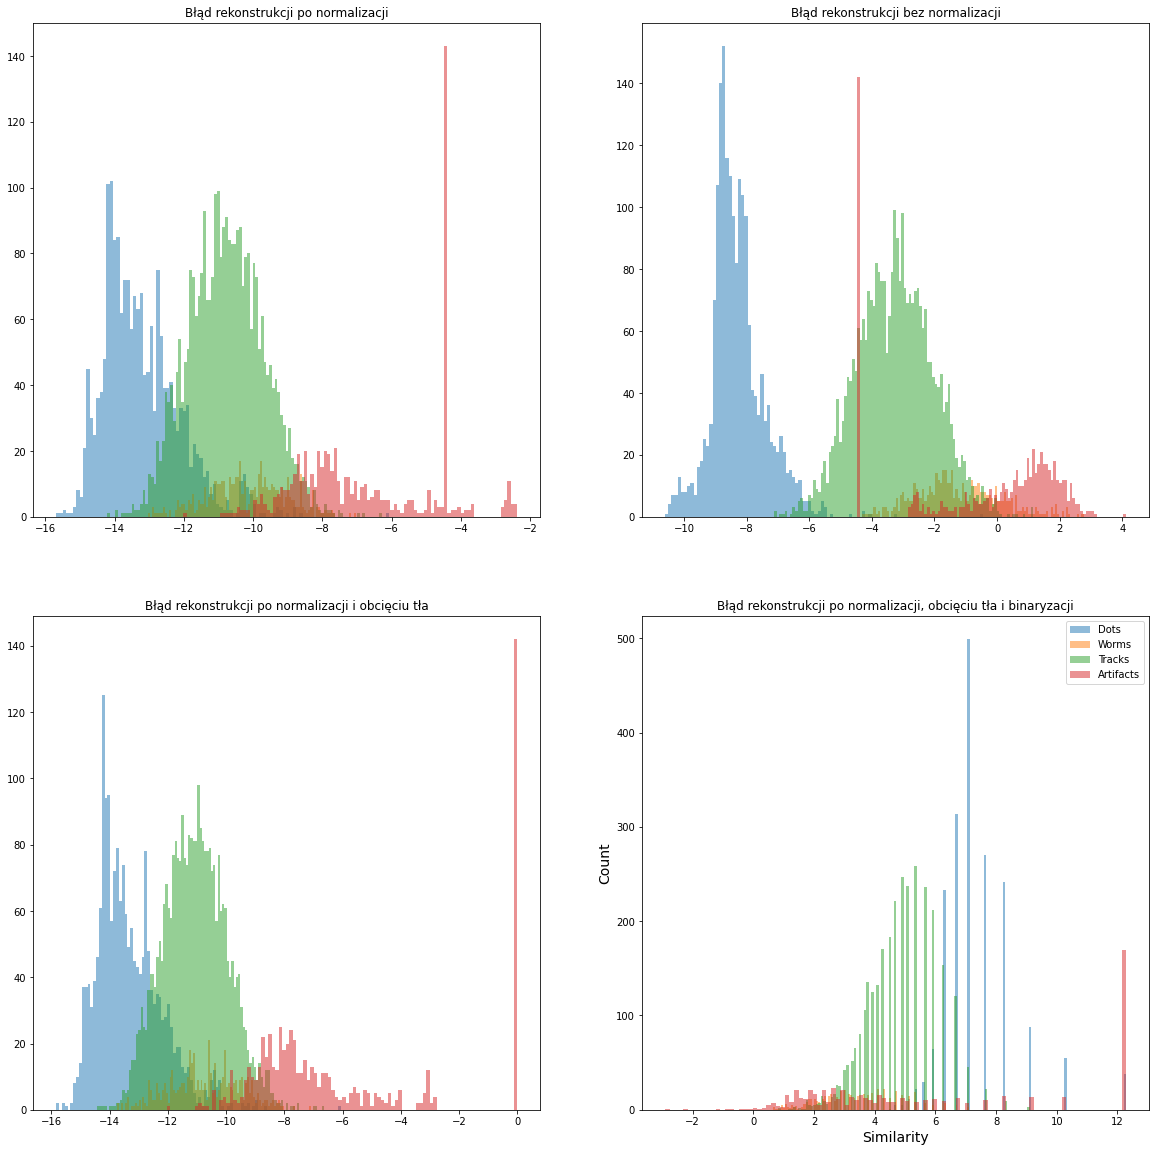

In [6]:
def dm_func_mean2(image, recon, normalize=True):
    blacks = 1
    if normalize:
        blacks = count_non_black_pixels(image)
    if blacks == 0:
        blacks = 1

    err = np.mean((image - recon) ** 2) / (blacks ** 2)
    return math.log2(err * 5000)


dots_reconstruction = dots_autoencoder.predict(dots_set)
worms_reconstruction = worms_autoencoder.predict(worms_set)
tracks_reconstruction = tracks_autoencoder.predict(tracks_set)
artifacts_reconstruction = artifacts_autoencoder.predict(artifacts_set)

fig, ((a0, a1), (a2, a3)) = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

a0.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Dots')
a0.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Worms')
a0.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Tracks')
a0.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Artifacts')
a0.set_title('Błąd rekonstrukcji po normalizacji')

a1.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Dots')
a1.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Worms')
a1.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Tracks')
a1.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Artifacts')
a1.set_title('Błąd rekonstrukcji bez normalizacji')

a2.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, cutoff_background=True), bins=100, alpha=0.5, label='Dots')
a2.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, cutoff_background=True), bins=100, alpha=0.5, label='Worms')
a2.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, cutoff_background=True), bins=100, alpha=0.5, label='Tracks')
a2.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, cutoff_background=True), bins=100, alpha=0.5, label='Artifacts')
a2.set_title('Błąd rekonstrukcji po normalizacji i obcięciu tła')

a3.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, normalize=True, cutoff_background=False, binarize_for_compare=True), bins=100, alpha=0.5, label='Dots')
a3.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, normalize=True, cutoff_background=False, binarize_for_compare=True), bins=100, alpha=0.5, label='Worms')
a3.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, normalize=True, cutoff_background=False, binarize_for_compare=True), bins=100, alpha=0.5, label='Tracks')
a3.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, normalize=True, cutoff_background=False, binarize_for_compare=True), bins=100, alpha=0.5, label='Artifacts')
a3.set_title('Błąd rekonstrukcji po normalizacji, obcięciu tła i binaryzacji')

plt.xlabel("Similarity", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

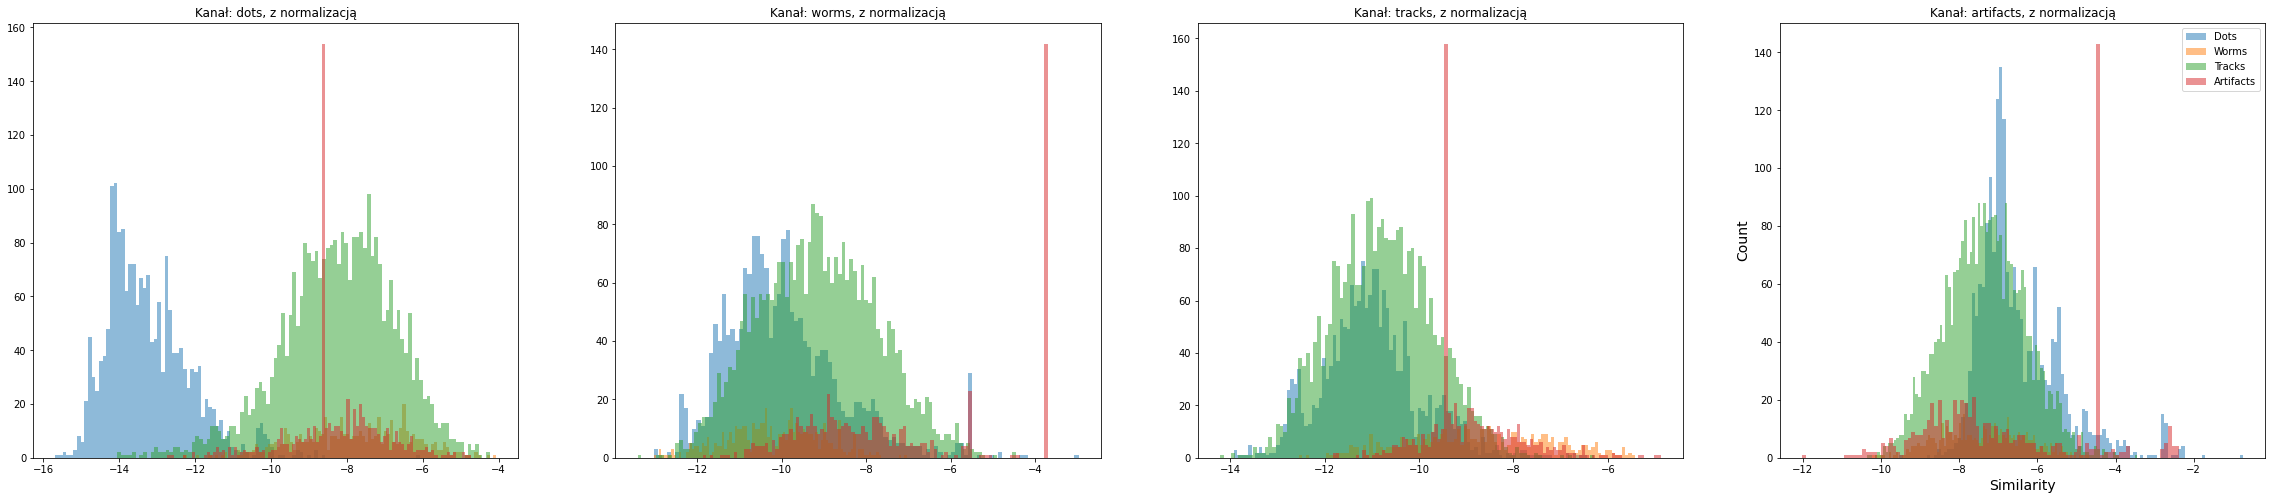

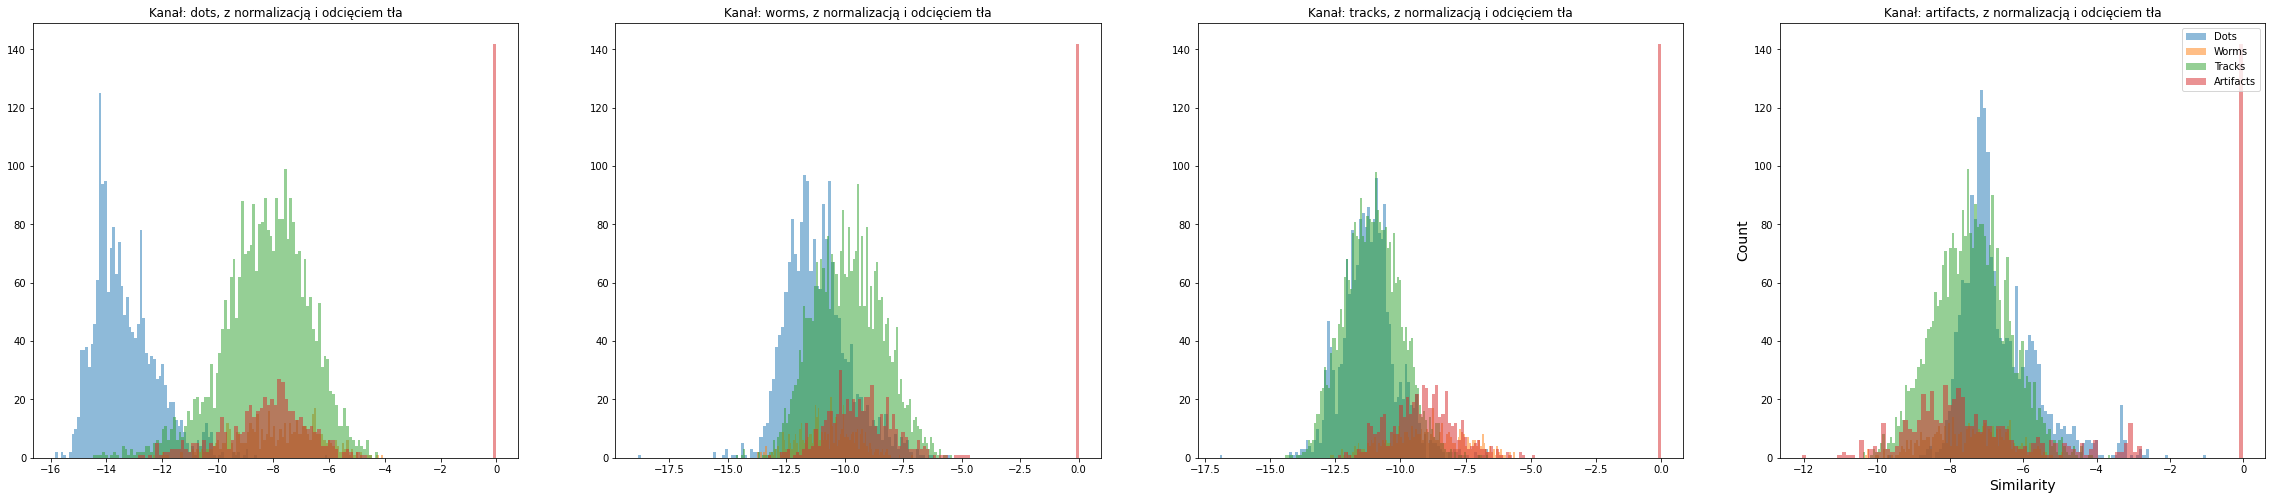

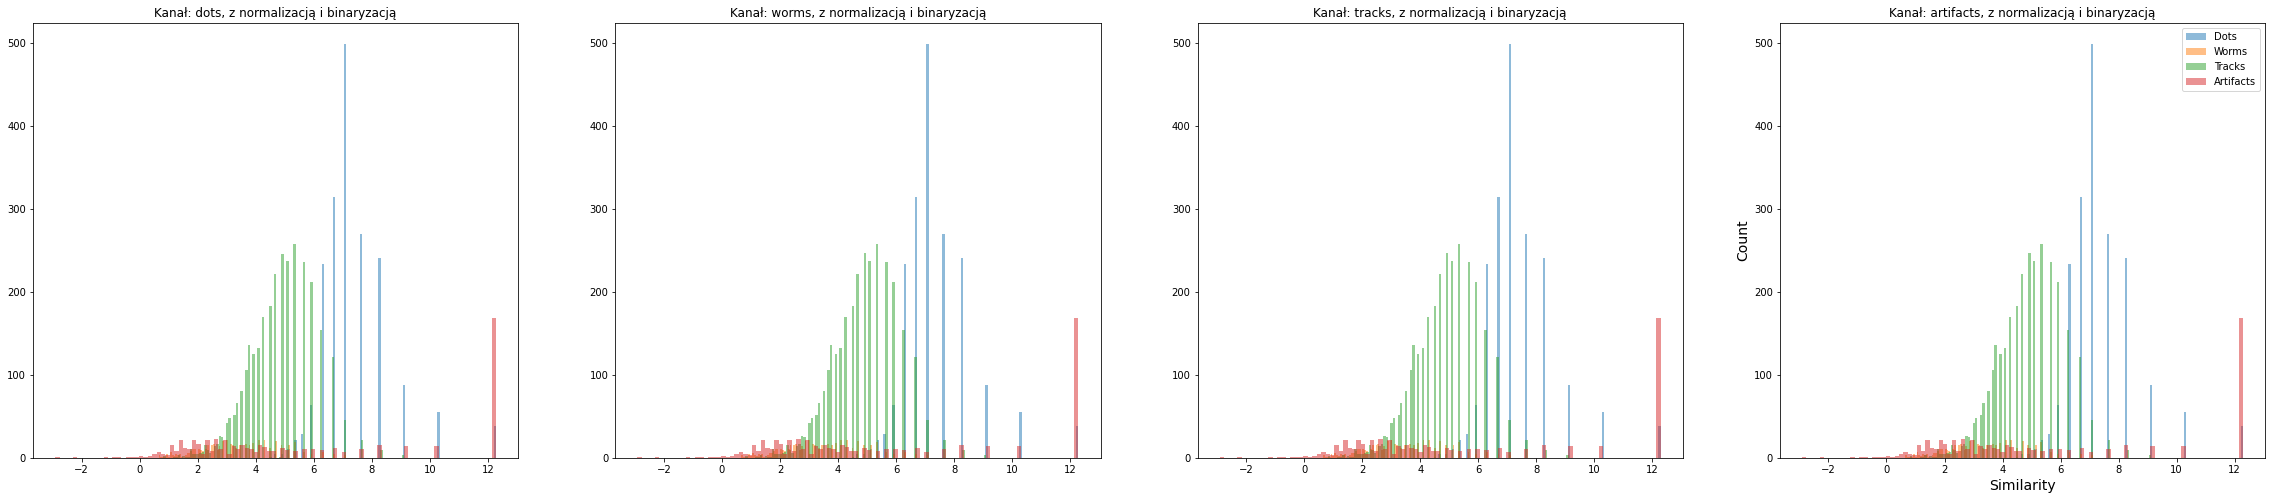

In [10]:
def channel_comparison(autoencoder, axis, title, **argv):
    dots_reconstruction = autoencoder.predict(dots_set)
    worms_reconstruction = autoencoder.predict(worms_set)
    tracks_reconstruction = autoencoder.predict(tracks_set)
    artifacts_reconstruction = autoencoder.predict(artifacts_set)

    axis.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, **argv), bins=100, alpha=0.5, label='Dots')
    axis.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, **argv), bins=100, alpha=0.5, label='Worms')
    axis.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, **argv), bins=100, alpha=0.5, label='Tracks')
    axis.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, **argv), bins=100, alpha=0.5, label='Artifacts')
    axis.set_title(title)

for [argv, title] in [
    [{'normalize': True, 'cutoff_background': False, 'binarize_for_compare': False}, 'z normalizacją'],
    [{'normalize': True, 'cutoff_background': True, 'binarize_for_compare': False}, 'z normalizacją i odcięciem tła'],
    [{'normalize': True, 'cutoff_background': False, 'binarize_for_compare': True}, 'z normalizacją i binaryzacją'],
]:
    fig, (ad, aw, at, aa) = plt.subplots(nrows=1, ncols=4, figsize=(40,8))
    channel_comparison(dots_autoencoder, ad, 'Kanał: dots, %s' % title, **argv)
    channel_comparison(worms_autoencoder, aw, 'Kanał: worms, %s' % title, **argv)
    channel_comparison(tracks_autoencoder, at, 'Kanał: tracks, %s' % title, **argv)
    channel_comparison(artifacts_autoencoder, aa, 'Kanał: artifacts, %s' % title, **argv)

    plt.xlabel("Similarity", size=14)
    plt.ylabel("Count", size=14)
    plt.legend(loc='upper right')
    plt.show()

# TODO: znaleźć punkt odcięcia kanału (kanał vs reszta, znaleźć w środku tak, żeby po lewej i po prawej było po równo false positive/negative)
# TODO: informacja wzajemna między obrazkiem oryginalnym a rekonstrukcją

In [27]:
def calc_similarity(autoencoder, **argv):
    dots_reconstruction = autoencoder.predict(dots_set)
    worms_reconstruction = autoencoder.predict(worms_set)
    tracks_reconstruction = autoencoder.predict(tracks_set)
    artifacts_reconstruction = autoencoder.predict(artifacts_set)

    return {
        'dots': prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, **argv),
        'worms': prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, **argv),
        'tracks': prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, **argv),
        'artifacts': prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, **argv)
    }

on_dots = calc_similarity(dots_autoencoder)
on_worms = calc_similarity(worms_autoencoder)
on_tracks = calc_similarity(tracks_autoencoder)
on_artifacts = calc_similarity(artifacts_autoencoder)

In [34]:
a = on_dots['dots']
b = on_dots['tracks']

np_a = np.array(a)
np_b = np.array(b)

np_a2 = np.vstack([np_a, np.ones(np_a.shape)])
np_a2 = np_a2.transpose()

np_b2 = np.vstack([np_a, np.ones(np_a.shape) * 2])
np_b2 = np_b2.transpose()

np_ab = np.vstack([np_a2, np_b2])
np_ab = np_ab[np_ab[:, 0].argsort()]

#np_dots2 = np.expand_dims(np_dots, axis=1)
pass


KeyboardInterrupt

